<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #8: Agrupación de textos
`Fecha de entrega: Abril 29, 2021. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [1]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [2]:
import re
import pandas as pd
from collections import Counter

from nltk.corpus import stopwords

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
stopwords_sp = stopwords.words('spanish')

from sklearn.feature_extraction.text import CountVectorizer

In [5]:
# Cargar datos
path = 'reviews_vidjew_es.csv'
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


###  `[10 pts]` Punto 1: Hacer pre-procesamiento del texto

In [6]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns=tfidf_vect.get_feature_names())
#tfidf_matrix

###  `[10 pts]` Punto 2: Método del codo para determinar $K$

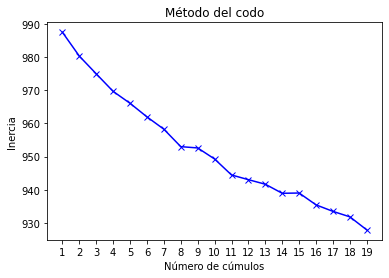

In [18]:
ks = []
k_inertias = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_

    ks.append(k)
    k_inertias.append(kmeans.inertia_)
    
plt.xlabel('Número de cúmulos')
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
plt.plot(ks, k_inertias, 'bx-');

###  `[10 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [19]:
k = 8
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [20]:
nbrs = NearestNeighbors(n_neighbors=4, metric="euclidean").fit(tfidf_matrix.values)
nbrs

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                 radius=1.0)

In [21]:
k = 8
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)
nbrs = NearestNeighbors(n_neighbors=4, metric="euclidean").fit(tfidf_matrix.values)

###  `[15 pts]` Punto 4: Interpretación de los clusters

In [22]:
data['cluster'] = model.labels_
clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)
 
centroides = model.cluster_centers_
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect.get_feature_names()

 
print(f"CLUSTERS:\n")
for i in range(k):
    print(f"Cluster #{i}")
    print(f"{clust_cnt[i]} textos ({clust_cnt_pct[i]:.2%} de los datos)")
    print(f"TERMINOS: ", end=" ")
    for idx in order_centroids[i, :15]:
        print(f"{terms[idx]}", end=" ")
    print("\n")
    print(f"Textos Representativos")
    for texto in data.iloc[nbrs.kneighbors([centroides[i]])[1][0]]['review_body'].values:
        print(f"* {texto}")
    print("\n")

CLUSTERS:

Cluster #0
147 textos (14.70% de los datos)
TERMINOS:  juego bien bonito español queda jugar cadena viene si pequeño colgante casi divertido buen funciona 

Textos Representativos
* Es un juego bonito y divertido, pero es que tiene excesivas paradas, me corta mucho el juego , está bien , pero..
* Esperaba más del juego.
* No me ha gustado el juego.
* El juego es muy bonito pero no está en español tal y como reseña


Cluster #1
375 textos (37.50% de los datos)
TERMINOS:  mando llegado si bonita día buen llegó foto solo pulsera queda tal pequeña fina gusta 

Textos Representativos
* La funda es tal cual la foto, cabe perfectamente la switch con los joycon acoplados, el doc, el soporte para los joycon, el cargador y el cable HDMI. Los huecos sujetan bien cada parte, probé a voltear varias veces la funda y todo se mantuvo en su sitio bien fijado así que me da seguridad por si tengo que transportar mi switch a otro lugar se que estará bien en esa funda, de momento me sirve para g

In [23]:
centroides.argsort()

array([[1629,  259, 1979, ...,  372,  350, 1885],
       [1102,  128,  714, ..., 3172, 1981, 2065],
       [2960, 2065, 2048, ..., 1990, 3378, 2535],
       ...,
       [1629,   29, 3100, ..., 1990, 2094, 2722],
       [1981, 1712, 2897, ..., 2673,  397,  446],
       [2770, 1990, 2048, ...,  350, 1220, 2960]])

In [24]:
terms[2535]

'perfecto'

In [25]:
#10 Palabras mas representativas del cluster 0
for ind in order_centroids[0][:10]:
  print(ind)
  print(terms[ind])

1885
juego
350
bien
372
bonito
1324
español
2810
queda
1894
jugar
431
cadena
3592
viene
3172
si
2514
pequeño


In [26]:
#Palabras mas representativas del cluster 7
for ind in order_centroids[7][:10]:
  print(ind)
  print(terms[ind])

2960
regalo
1220
encantó
350
bien
372
bonito
2673
precio
396
buen
446
calidad
1162
día
1658
gustado
686
compré


###  `[BONUS: 3 pts]` Visualización usando PCA

In [27]:

pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = data.cluster.values
result['review_body'] = data.review_body.values

trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['review_body'].values,
                   mode='markers',
                   marker=dict(color=result['cluster'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

# Comparación

### `[BONUS 20 pts (validos para cualquier tarea)]` 
### Hacer predicción para estas dos frases de los dos modelos (clasificación y $k$-means)

In [17]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]

### `[5 pts]` Punto 5: Preguntas

- Según los resultados del $K$-Means, ¿cuál es la estructura de los datos?
- ¿Qué diferencia notó entre los resultados del taller pasado y este?
- ¿Alguna otra observación?



## *   Según los resultados del  K -Means, ¿cuál es la estructura de los datos? 

RTA :En la  estructura de los datos en K-Means busca juntar las observaciones mas similares

## *   ¿Qué diferencia notó entre los resultados del taller pasado y este?

RTA :Este modelo es mas lento para entrenar y fue mas efectivo el modelo del taller anterior 

##*   ¿Alguna otra observación?

RTA :Es importante tener conocimiento del tema para poder saber interpretarlo y optimizarlo de acuerdo a los resultados obtenidos


